# CSE6240 Homework1 - Analyzing a Movie Review Dataset
Name: Yang Wu

GT username: ywu613

Datasets come from Kaggle competition [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial)

## 0. Reading and cleaning the data

In [1]:
# the labeled training data
import pandas as pd
import numpy as np
import scipy as sp
train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)

In [ ]:
# First, install Beautiful Soup library
# !pip install beautifulsoup4

In [2]:
import re
import nltk
# nltk.download()  # Download text data sets, including stop words
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 

In [3]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "html.parser").get_text()
    #
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    #
    # 6. Join the words back into one string separated by space,
    # and return the result.
    return( " ".join( meaningful_words ))

In [4]:
# Create an empty list and append the clean reviews one by one
num_train_reviews = len(train["review"])
clean_train_reviews = [] 

print("Cleaning and parsing the train set movie reviews...\n")
for i in range(0, num_train_reviews):
    if((i + 1) % 5000 == 0):
        print("Review %d of %d\n" % (i + 1, num_train_reviews))
    clean_train_reviews.append(review_to_words(train["review"][i]))
print("Done!")

Cleaning and parsing the train set movie reviews...

Review 5000 of 25000

Review 10000 of 25000

Review 15000 of 25000

Review 20000 of 25000

Review 25000 of 25000

Done!


In [5]:
# Create an empty list and append the clean reviews one by one
num_test_reviews = len(test["review"])
clean_test_reviews = [] 

print("Cleaning and parsing the test set movie reviews...\n")
for i in range(0, num_test_reviews):
    if((i + 1) % 5000 == 0):
        print("Review %d of %d\n" % (i + 1, num_test_reviews))
    clean_test_reviews.append(review_to_words(test["review"][i]))
print("Done!")

Cleaning and parsing the test set movie reviews...

Review 5000 of 25000

Review 10000 of 25000

Review 15000 of 25000

Review 20000 of 25000

Review 25000 of 25000

Done!


## 1. Processing text to create design matrices

In [6]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer
 
count_vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, 
                                   stop_words = None, max_features = 5000) 

X_counts = count_vectorizer.fit_transform(clean_train_reviews)
print("Done!")

Creating the bag of words...

Done!


In [7]:
print("Creating the binary bag of words...\n")

from copy import deepcopy
X_binary = deepcopy(X_counts)
X_binary[X_binary > 0] = 1

print("Done!")

Creating the binary bag of words...

Done!


In [8]:
print("Creating the tf–idf term weighting...\n")
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf = False)
X_tfidf = transformer.fit_transform(X_counts)

print("Done!")

Creating the tf–idf term weighting...

Done!


In [9]:
print("Creating the imbalance binary bag of words...\n")

df = train[train["sentiment"] == 1].sample(frac = 0.75, random_state = 0)
imbalance_train = train.drop(df.index)
X_binary_imbalance = X_binary[imbalance_train.index]

print("Done!")

Creating the imbalance binary bag of words...

Done!


## 2. Feature space similarity experiment

In [10]:
# Obtain the label on the original train set and imbalance train set
train_sentiment = train["sentiment"].values
imbalance_train_sentiment = imbalance_train["sentiment"].values

In [11]:
from sklearn.metrics.pairwise import pairwise_distances
def dist(X, i, j, distance_function = "euclidean"):
    return pairwise_distances(X[i], X[j], metric = distance_function)[0, 0]

In [12]:
def topk(X, k):
    # compute the distance matrix
    distance = pairwise_distances(X, n_jobs=1)
    # remove duplicate values and diagonal values, then flat the matrix
    indices = np.tril_indices(distance.shape[0])
    distance[indices] = np.inf
    flat = distance.flatten()
    
    # find the top k closedt rows
    index = np.argpartition(flat, k)[:k]
    index = index[np.argsort(flat[index])]
    index = np.unravel_index(index, distance.shape)
    
    top = []
    for i in range(k):
        row = index[0][i]
        col = index[1][i]
        top.append([row, col, distance[row][col]])
    return top

In [13]:
# compute top k for X_counts matrix
top = topk(X_counts, 5)

for elm in top:
    print("The indices are", (elm[0], elm[1]), "and the distance is", elm[2])
    print("for", elm[0], "th review:", train["review"][elm[0]][:20], ", and its sentiment is", train["sentiment"][elm[0]])
    print("for", elm[1], "th review:", train["review"][elm[1]][:20], ", and its sentiment is", train["sentiment"][elm[1]])

The indices are (3924, 5796) and the distance is 0.0
for 3924 th review: "I watched this movi , and its sentiment is 0
for 5796 th review: "I watched this movi , and its sentiment is 0
The indices are (4937, 7794) and the distance is 0.0
for 4937 th review: "A longtime fan of B , and its sentiment is 1
for 7794 th review: "A longtime fan of B , and its sentiment is 1
The indices are (5766, 11510) and the distance is 0.0
for 5766 th review: "I saw this in the s , and its sentiment is 0
for 11510 th review: "I saw this in the s , and its sentiment is 0
The indices are (4543, 12168) and the distance is 0.0
for 4543 th review: "Smallville episode  , and its sentiment is 1
for 12168 th review: "Smallville episode  , and its sentiment is 1
The indices are (7765, 9776) and the distance is 0.0
for 7765 th review: "How has this piece  , and its sentiment is 0
for 9776 th review: "How has this piece  , and its sentiment is 0


In [14]:
# compute top k for X_binary matrix
top = topk(X_binary, 5)

for elm in top:
    print("The indices are", (elm[0], elm[1]), "and the distance is", elm[2])
    print("for", elm[0], "th review:", train["review"][elm[0]][:20], ", and its sentiment is", train["sentiment"][elm[0]])
    print("for", elm[1], "th review:", train["review"][elm[1]][:20], ", and its sentiment is", train["sentiment"][elm[1]])

The indices are (1290, 1355) and the distance is 0.0
for 1290 th review: "I am not so much li , and its sentiment is 0
for 1355 th review: "I am not so much li , and its sentiment is 0
The indices are (7667, 12234) and the distance is 0.0
for 7667 th review: "You know all those  , and its sentiment is 0
for 12234 th review: "You know all those  , and its sentiment is 0
The indices are (8117, 8136) and the distance is 0.0
for 8117 th review: "This was one of the , and its sentiment is 0
for 8136 th review: "This was one of the , and its sentiment is 0
The indices are (5656, 10451) and the distance is 0.0
for 5656 th review: "Goodnight, Mister T , and its sentiment is 0
for 10451 th review: "Goodnight, Mister T , and its sentiment is 0
The indices are (7765, 9776) and the distance is 0.0
for 7765 th review: "How has this piece  , and its sentiment is 0
for 9776 th review: "How has this piece  , and its sentiment is 0


In [15]:
# compute top k for X_tfidf matrix
top = topk(X_tfidf, 5)

for elm in top:
    print("The indices are", (elm[0], elm[1]), "and the distance is", elm[2])
    print("for", elm[0], "th review:", train["review"][elm[0]][:20], ", and its sentiment is", train["sentiment"][elm[0]])
    print("for", elm[1], "th review:", train["review"][elm[1]][:20], ", and its sentiment is", train["sentiment"][elm[1]])

The indices are (2804, 4762) and the distance is 0.0
for 2804 th review: "I think this is alm , and its sentiment is 0
for 4762 th review: "I think this is alm , and its sentiment is 0
The indices are (4937, 7794) and the distance is 0.0
for 4937 th review: "A longtime fan of B , and its sentiment is 1
for 7794 th review: "A longtime fan of B , and its sentiment is 1
The indices are (1461, 6013) and the distance is 0.0
for 1461 th review: "I really enjoyed th , and its sentiment is 1
for 6013 th review: "I really enjoyed th , and its sentiment is 1
The indices are (5065, 6691) and the distance is 0.0
for 5065 th review: "German filmmaker Ul , and its sentiment is 0
for 6691 th review: "German filmmaker Ul , and its sentiment is 0
The indices are (1290, 1355) and the distance is 0.0
for 1290 th review: "I am not so much li , and its sentiment is 0
for 1355 th review: "I am not so much li , and its sentiment is 0


In [16]:
# compute top k for X_binary_imbalance matrix
top = topk(X_binary_imbalance, 5)

# use imbalance_train to get reviews and sentiments
for elm in top:
    i, j = imbalance_train.index[elm[0]], imbalance_train.index[elm[1]]
    print("The indices are", (i, j), "and the distance is", elm[2])
    print("for", i, "th review:", imbalance_train["review"].values[elm[0]][:20], 
          ", and its sentiment is", imbalance_train["sentiment"].values[elm[0]])
    print("for", j, "th review:", imbalance_train["review"].values[elm[1]][:20], 
          ", and its sentiment is", imbalance_train["sentiment"].values[elm[1]])

The indices are (15290, 18042) and the distance is 0.0
for 15290 th review: "This show comes up  , and its sentiment is 0
for 18042 th review: "This show comes up  , and its sentiment is 0
The indices are (15290, 17736) and the distance is 0.0
for 15290 th review: "This show comes up  , and its sentiment is 0
for 17736 th review: "This show comes up  , and its sentiment is 0
The indices are (7765, 9776) and the distance is 0.0
for 7765 th review: "How has this piece  , and its sentiment is 0
for 9776 th review: "How has this piece  , and its sentiment is 0
The indices are (326, 7336) and the distance is 0.0
for 326 th review: "This guy has no ide , and its sentiment is 0
for 7336 th review: "This guy has no ide , and its sentiment is 0
The indices are (2905, 16147) and the distance is 0.0
for 2905 th review: "The original \"les  , and its sentiment is 0
for 16147 th review: "The original \"les  , and its sentiment is 0


As we can see above, the top $k$ closest pairs of review are different among those four design matrices.

## 3. Classification experiment

In [25]:
import matplotlib.pyplot as plt
import random as rd

from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

In [26]:
# calculateAUC(X, y, k = 5) return two list which record 
# all randomly selected c and corresponding auc scores
# input: 
# X - features
# y - label or sentiment
# k - number of cross validation
def calculateAUC(X, y, k = 5):
    rd.seed(0)
    cv = KFold(n_splits = k)
    c_list = []
    auc_list = []
    
    for i in range(30):
        c = rd.uniform(-4, 4)
        c = 10**c
        classifier = svm.LinearSVC(C = c)
        
        mean_auc = 0
        
        for train, test in cv.split(X, y):
            y_score = classifier.fit(X[train], y[train]).decision_function(X[test])
            # Compute ROC curve and area the curve
            roc_auc = roc_auc_score(y[test], y_score)
            mean_auc += roc_auc
            
        mean_auc /= cv.get_n_splits(X, y)
        
        c_list.append(c)
        auc_list.append(mean_auc)
        
    return c_list, auc_list

In [27]:
# findBestC(X, y, k) return the best performance c, and the improvement in roc_auc
# input:
# X - features
# y - label or sentiment
# k - number of cross validation
def findBestC(X, y, k = 5):
    c_list, auc_list = calculateAUC(X, y, k = 5)
    best = np.argmax(auc_list)
    worst = np.argmin(auc_list)
    return c_list[best], auc_list[best] - auc_list[worst]

In [28]:
# plotROC(fpr, tpr, roc_auc, name) will plot the roc curve
# input:
# fpr     - false positive rate
# tpr     - true positive rate
# roc_auc - auc scores
# name    - design matrix 
def plotROC(fpr, tpr, roc_auc, name):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color = 'darkorange', lw = lw, label = 'ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + name)
    plt.legend(loc = "lower right")
    plt.show()

### 3.1. Tune an SVM classifier using X_counts

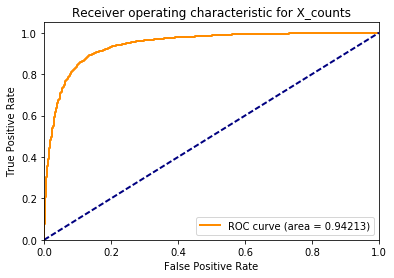

The improvement in ROC-AUC of X_counts design matrix is 0.045291386672


In [29]:
# Split the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_counts, train_sentiment, test_size = 0.2, random_state = 0)

c_best, improvement = findBestC(X_train, y_train, 5)
classifier = svm.LinearSVC(C = c_best).fit(X_train, y_train)
fpr, tpr, _ = roc_curve(y_test, classifier.decision_function(X_test))
roc_auc = auc(fpr, tpr)
plotROC(fpr, tpr, roc_auc, "X_counts")
print("The improvement in ROC-AUC of X_counts design matrix is", improvement)

In [30]:
# Retrain svm using all X_counts data
clf1 = svm.LinearSVC(C = c_best).fit(X_counts, train_sentiment)

In [31]:
# Create the bag of words from test data
X_counts_test = count_vectorizer.transform(clean_test_reviews)

# Generate labels on Kaggle's test data
result1 = clf1.predict(X_counts_test)

# Copy the results to a pandas dataframe with an "id" column and a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result1} )

# Use pandas to write the comma-separated output file
output.to_csv( "Bag_of_Words_model1.csv", index = False, quoting = 3 )

The Kaggle score using X_counts is 0.86928.

### 3.2. Tune an SVM classifier using X_binary

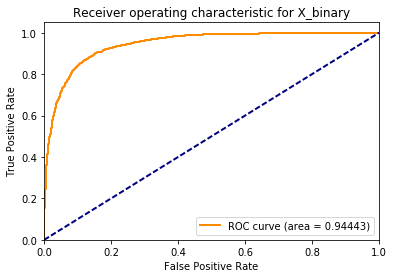

The improvement in ROC-AUC of X_binary design matrix is 0.0468880836856


In [32]:
# Split the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_binary, train_sentiment, test_size = 0.2, random_state = 0)

c_best, improvement = findBestC(X_train, y_train, 5)
classifier = svm.LinearSVC(C = c_best).fit(X_train, y_train)
fpr, tpr, _ = roc_curve(y_test, classifier.decision_function(X_test))
roc_auc = auc(fpr, tpr)
plotROC(fpr, tpr, roc_auc, "X_binary")
print("The improvement in ROC-AUC of X_binary design matrix is", improvement)

In [33]:
# Retrain svm using all X_binary data
clf2 = svm.LinearSVC(C = c_best).fit(X_binary, train_sentiment)

In [34]:
# Transfer X_counts_test to X_binary_test
X_binary_test = deepcopy(X_counts_test)
X_binary_test[X_binary_test > 0] = 1

# Generate labels on Kaggle's test data
result2 = clf2.predict(X_binary_test)
output = pd.DataFrame( data={"id":test["id"], "sentiment":result2} )
output.to_csv( "Bag_of_Words_model2.csv", index = False, quoting = 3 )

The Kaggle score using X_binary is 0.87296.

### 3.3. Tune an SVM classifier using X_tfidf

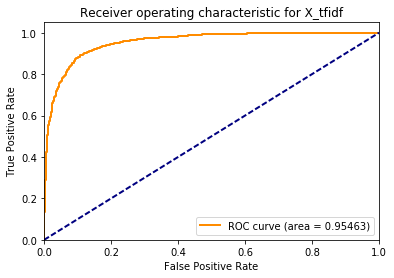

The improvement in ROC-AUC of X_tfidf design matrix is 0.0478953865898


In [35]:
# Split the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, train_sentiment, test_size = 0.2, random_state = 0)

c_best, improvement = findBestC(X_train, y_train, 5)
classifier = svm.LinearSVC(C = c_best).fit(X_train, y_train)
fpr, tpr, _ = roc_curve(y_test, classifier.decision_function(X_test))
roc_auc = auc(fpr, tpr)
plotROC(fpr, tpr, roc_auc, "X_tfidf")
print("The improvement in ROC-AUC of X_tfidf design matrix is", improvement)

In [36]:
# Retrain svm using all X_tfidf data
clf3 = svm.LinearSVC(C = c_best).fit(X_tfidf, train_sentiment)

In [37]:
# Transfer X_counts_test to X_tfidf_test
X_tfidf_test = transformer.transform(X_counts_test)

# Generate labels on Kaggle's test data
result3 = clf3.predict(X_tfidf_test)
output = pd.DataFrame( data={"id":test["id"], "sentiment":result3} )
output.to_csv( "Bag_of_Words_model3.csv", index = False, quoting = 3 )

The Kaggle score using X_tfidf is 0.87988.

### 3.4. Tune an SVM classifier using X_binary_imbalance

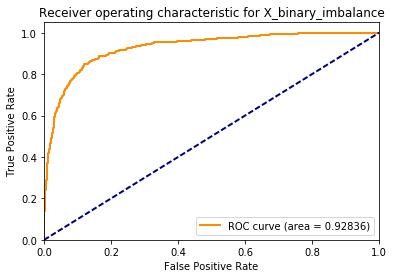

The improvement in ROC-AUC of X_binary_imbalance design matrix is 0.0361306660191


In [38]:
# Split the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_binary_imbalance, imbalance_train_sentiment, 
                                                    test_size = 0.2, random_state = 0)

c_best, improvement = findBestC(X_train, y_train, 5)
classifier = svm.LinearSVC(C = c_best).fit(X_train, y_train)
fpr, tpr, _ = roc_curve(y_test, classifier.decision_function(X_test))
roc_auc = auc(fpr, tpr)
plotROC(fpr, tpr, roc_auc, "X_binary_imbalance")
print("The improvement in ROC-AUC of X_binary_imbalance design matrix is", improvement)

In [39]:
# Retrain svm using all X_binary_imbalance data
clf4 = svm.LinearSVC(C = c_best).fit(X_binary_imbalance, imbalance_train_sentiment)

Because we don't have the sentiments of the test set, the X_binary_test will be used to predict the result.

In [40]:
# Generate labels on Kaggle's test data
result4 = clf4.predict(X_binary_test)
output = pd.DataFrame( data={"id":test["id"], "sentiment":result4} )
output.to_csv( "Bag_of_Words_model4.csv", index = False, quoting = 3 )

The Kaggle score using X_binary_imbalance is 0.80676.

As we can see, X_tfidf has the largest roc-auc score and thus performs best.

## 4. Learning curve experiment

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

In [42]:
train_sizes = [100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000]
_, train_scores, test_scores = learning_curve(LogisticRegression(), X_counts, train_sentiment,
                                              cv = 5, train_sizes = train_sizes)

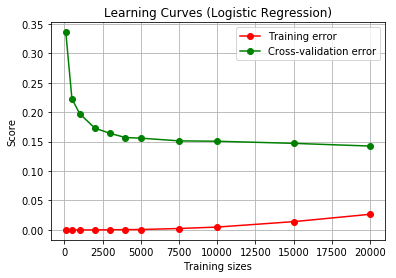

In [51]:
train_errors_mean = 1 - np.mean(train_scores, axis = 1)
test_errors_mean = 1 - np.mean(test_scores, axis = 1)

# Plot the learning curve
plt.figure()
plt.grid()
plt.title("Learning Curves (Logistic Regression)")
plt.xlabel("Training sizes")
plt.ylabel("Score")
plt.plot(train_sizes, train_errors_mean, 'o-', color = "r", label = "Training error")
plt.plot(train_sizes, test_errors_mean, 'o-', color = "g", label = "Cross-validation error")
plt.legend(loc = "best")
plt.show()

In the learning curve plot, the gap between training and test errors becomes smaller with larger training size. At the beginning, training size is small (says less than 2500) with a extremely small training error. In contrast, testing error (cross-validation error) is quite large. This indicate that our model is overfitted. Then as the number of training examples increases, the testing error decreases dramatically. This demonstrates that large training datasets can overcomes overfitting. 